In [202]:
import numpy as np
import lightgbm as lgb
import enum
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
plt.style.use("dark_background")
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)


In [203]:
df = pd.read_csv('/Users/rs/Documents/white parus jun quant/volatility_task.csv')
df['ts'] = pd.to_datetime(df['ts'])

In [204]:
df['stock return'] = np.log(df['close']).diff()
df.head()

,ts,open,high,low,close,stock return
0,2023-01-01 00:00:00,16541.77,16544.76,16538.45,16543.67,NaN
1,2023-01-01 00:01:00,16543.04,16544.41,16538.48,16539.31,-0.000264
2,2023-01-01 00:02:00,16539.31,16541.17,16534.52,16536.43,-0.000174
3,2023-01-01 00:03:00,16536.43,16537.28,16531.00,16533.65,-0.000168
4,2023-01-01 00:04:00,16534.12,16536.08,16527.51,16535.38,0.000105


## 1. Смоделируем движение цены геометрическим броуновским движением 

### Geometric Brownian Motion (GBM)

S - стоимость актива, $\mu$ - drift , $\sigma$ - volatility:
$$
\frac{\text{d}S_t}{S_t} = \mu \text{d}t + \sigma\text{d}W_t
$$
Броуновский член $\text{d}W_t $ имеет вид: 
$$
\text{d}W_t = \epsilon\sqrt{{d}t}
$$
где $\epsilon$ - нормально распределенная слечайная величина N(0,1) 

In [205]:
def cross_threshold(n_paths, n_steps, dt, S0, sigma, drift, threshold, plot = True, n_paths_plot = 25):
    paths_gbm = np.zeros((n_paths, n_steps+1))
    paths_gbm[:, 0] = S0

    for i in range(1, n_steps+1):
        dW = np.random.normal(0, 1, n_paths)*np.sqrt(dt)
        S = paths_gbm[:, i-1]
        paths_gbm[:, i] = S * (1 + drift * dt + sigma * dW)
    
    if threshold>0:
        result = np.any(paths_gbm > S0 + threshold, axis=1)
    
    else: 
        result = np.any(paths_gbm < S0 + threshold, axis=1)
        
    prob = sum(result)/len(result)
    
    if plot:
        time_arr = np.linspace(0, n_steps * dt, n_steps + 1)
        plt.figure(figsize=(20, 10))
        for i in range(n_paths_plot):
            plt.plot(time_arr, paths_gbm[i])
        plt.axhline(S0 + threshold, ls='--', label='Strike', c='darkred', linewidth=5.0)
        plt.xlabel('Time, mins')
        plt.ylabel('Price, usdt')
        plt.title('GBM price paths')
        plt.grid()
        plt.show()
        print('Вероятность пересечения границы: ', prob)
        
    return prob

установим значения параметров:

In [206]:
n_paths = 1000000
horisont = 120
dt = 1 # минута 
threshold = -500
sigma = 0.00049 # минутная
S0 = 27293
drift = -1.056e-05 # минутная

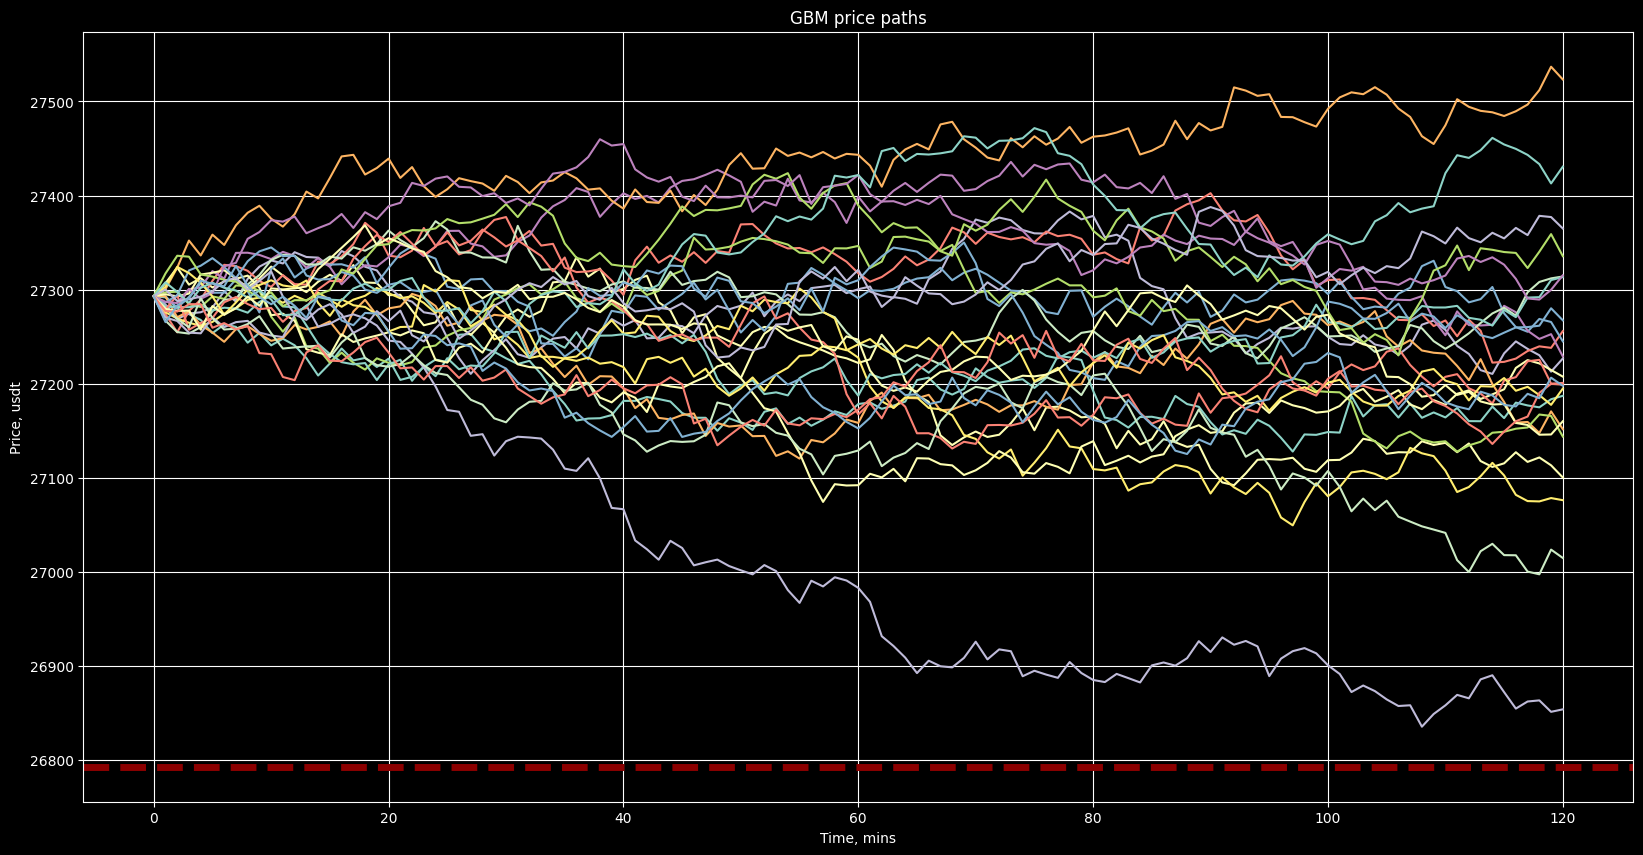

Вероятность пересечения границы:  0.001054


0.001054

In [207]:
cross_threshold(n_paths, horisont, dt, S0, sigma, drift, threshold, n_paths_plot = 25)

Теперь главным вопросом становится, какие значения минутных дрифта и волатильности выбрать для модели.

## 2. Посмотрим на минутные доходности

In [208]:
def plot_normalized_histogram(data, column_name, bins=30, xlim = 0.01):
    plt.figure(figsize=(5, 3))
    plt.hist(data[column_name], bins=bins, edgecolor='k', density=True)

    plt.title(f'Нормированная гистограмма столбца "{column_name}"', fontweight='bold')
    plt.xlabel(f'Значения "{column_name}"')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.xlim(-xlim, xlim)

    plt.show()
    return data[column_name].mean(), data[column_name].std() 

def plot_close_data(df, num_points=1440):
    plt.figure(figsize=(5, 3)) 

    plt.plot(df.tail(num_points)['ts'], df.tail(num_points)['close'])  
    plt.title('График столбца close')  
    plt.xlabel('Время')  
    plt.ylabel('Значение close')  

    plt.grid(True)  
    plt.show()

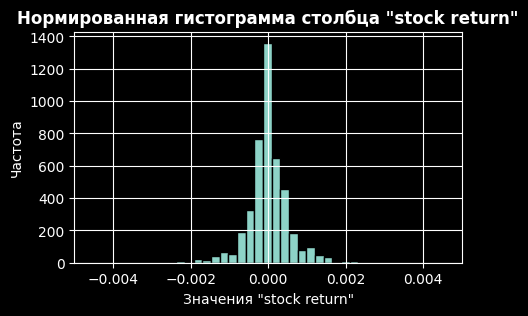

(-1.626902194160371e-06, 0.0005928331544111638)

In [209]:
plot_normalized_histogram(df.tail(720), 'stock return', bins=40 , xlim = 0.005)

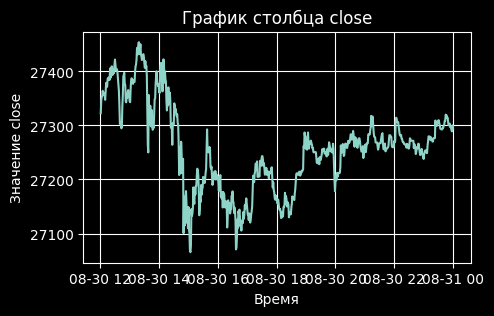

In [210]:
plot_close_data(df, num_points=720)

Видим, что сначала волатильность была относительно сильной, потом спала. Но по гистограмме мы этого не заметим.
Будем использовать значение минутной волатильности посчитанной по предистории соизмеримой с горизонтом прогноза.

In [211]:
df['std_60'] = df['stock return'].rolling(window=60).std()
df['mean_60'] = df['stock return'].rolling(window=60).mean()
df['std_120'] = df['stock return'].rolling(window=120).std()
df['mean_120'] = df['stock return'].rolling(window=120).mean()
df['std_360'] = df['stock return'].rolling(window=360).std()
df['mean_360'] = df['stock return'].rolling(window=360).mean()
df['std_720'] = df['stock return'].rolling(window=720).std()
df['mean_720'] = df['stock return'].rolling(window=720).mean()
df.dropna(inplace = True)
df.drop(['open', 'high', 'low'], axis=1, inplace=True)

In [212]:
df.head()

,ts,close,stock return,std_60,mean_60,std_120,mean_120,std_360,mean_360,std_720,mean_720
720,2023-01-01 12:00:00,16556.93,0.000016,0.000096,0.000009,0.000101,0.000009,0.000144,0.000004,0.000148,0.000001
721,2023-01-01 12:01:00,16556.27,-0.000040,0.000094,0.000010,0.000100,0.000011,0.000144,0.000003,0.000147,0.000001
722,2023-01-01 12:02:00,16558.04,0.000107,0.000095,0.000012,0.000100,0.000011,0.000144,0.000003,0.000147,0.000002
723,2023-01-01 12:03:00,16557.38,-0.000040,0.000095,0.000010,0.000100,0.000011,0.000144,0.000003,0.000147,0.000002
724,2023-01-01 12:04:00,16562.56,0.000313,0.000102,0.000017,0.000104,0.000014,0.000145,0.000004,0.000148,0.000002


Если предсказывать нужно на период 10 - 30 минут, то будем использовать std_60, mean_60 (за последние 60 минут);

Если на период 30 - 60, то будем использовать std_120, mean_120;
Если на период 60 - 90, то будем использовать std_360, mean_360;
Если на период 90 - 120, то будем использовать std_720, mean_720;

## 3. Бэктест

Разобьем данные на чанки по 60 строк (horisont): 

- по первой строке посчитаем вероятность пересечения границы на горизонте в 60 шагов (минут).

- по следующим 59 строкам посмотрим, удалось ли цене пробить границу (True/False) 

- запишем эти данные в df_res

In [213]:
chunk_size = 60
data = []
chunks = np.array_split(df, len(df) / chunk_size)

In [214]:
for chunk in tqdm(chunks):
    
    n_paths = 10000
    horisont = 60
    dt = 1 
    threshold = 100
    sigma = chunk.iloc[0].std_60
    S0 = chunk.iloc[0].close
    drift = chunk.iloc[0].mean_60
    prob = cross_threshold(n_paths, horisont, dt, S0, sigma, drift, threshold, plot = False, n_paths_plot = 25)
    if threshold > 0:
        data.append([chunk.iloc[0].ts, chunk.iloc[0].close,\
                 chunk.iloc[0].mean_60, chunk.iloc[0].std_60,\
                 prob, np.any(chunk.close > S0 + threshold)])
    else:
        data.append([chunk.iloc[0].ts, chunk.iloc[0].close,\
                 chunk.iloc[0].mean_60, chunk.iloc[0].std_60,\
                 prob, np.any(chunk.close < S0 + threshold)])


100%|███████████████████████████████████████| 5794/5794 [03:19<00:00, 29.00it/s]


In [215]:
df_res = pd.DataFrame(data, columns=['ts', 'close', 'mean', 'std', 'probability', 'result'])

In [216]:
df_res.head()

,ts,close,mean,std,probability,result
0,2023-01-01 12:00:00,16556.93,0.000009,0.000096,0.0000,False
1,2023-01-01 13:01:00,16562.84,0.000007,0.000176,0.0000,False
2,2023-01-01 14:02:00,16550.66,-0.000013,0.000130,0.0000,False
3,2023-01-01 15:03:00,16545.18,-0.000006,0.000097,0.0000,False
4,2023-01-01 16:04:00,16563.20,0.000018,0.000158,0.0001,False


- Из всех данных выберем те, где предсказанная вероятность лежит в пределах [a, b] 
- Посчитаем в скольких из этих данным цена действительно пробила границу.

In [226]:
df_sliced = df_res[(df_res['probability'] >= 0) & (df_res['probability'] <= 0.1)]
df_sliced['result'].sum()/len(df_sliced['result'])

0.10174418604651163

In [227]:
df_sliced = df_res[(df_res['probability'] >= 0.1) & (df_res['probability'] <= 0.2)]
df_sliced['result'].sum()/len(df_sliced['result'])

0.19329896907216496

In [228]:
df_sliced = df_res[(df_res['probability'] >= 0.2) & (df_res['probability'] <= 0.3)]
df_sliced['result'].sum()/len(df_sliced['result'])

0.2271186440677966

In [229]:
df_sliced = df_res[(df_res['probability'] >= 0.4) & (df_res['probability'] <= 0.5)]
df_sliced['result'].sum()/len(df_sliced['result'])

0.2559366754617414

In [230]:
df_sliced = df_res[(df_res['probability'] >= 0.5) & (df_res['probability'] <= 0.6)]
df_sliced['result'].sum()/len(df_sliced['result'])

0.27761194029850744

In [231]:
df_sliced = df_res[(df_res['probability'] >= 0.6) & (df_res['probability'] <= 0.7)]
df_sliced['result'].sum()/len(df_sliced['result'])

0.33211678832116787

In [232]:
df_sliced = df_res[(df_res['probability'] >= 0.7) & (df_res['probability'] <= 0.8)]
df_sliced['result'].sum()/len(df_sliced['result'])

0.3445378151260504

In [233]:
df_sliced = df_res[(df_res['probability'] >= 0.8) & (df_res['probability'] <= 0.9)]
df_sliced['result'].sum()/len(df_sliced['result'])

0.3352941176470588

In [234]:
df_sliced = df_res[(df_res['probability'] >= 0.9) & (df_res['probability'] <= 1.0)]
df_sliced['result'].sum()/len(df_sliced['result'])

0.49624060150375937

Видим хорошее описание данных при вероятностях от 0 до 0.3, и ухудшение точности предсказания при p > 0.4.
В целом, при увеличении предсказанной вероятности, реальная вероятность тоже растет, что неплохо.

In [235]:
def chunk_back_test(df, threshold, horisont=60):
    data = []
    dt=1
    n_paths=10000
    chunk_size=horisont
    chunks = np.array_split(df, len(df) / chunk_size)

    for chunk in tqdm(chunks):
        if 10 <= horisont <= 30:
            sigma = chunk.iloc[0].std_60
            drift = chunk.iloc[0].mean_60
        elif 30 < horisont <= 60:
            sigma = chunk.iloc[0].std_120
            drift = chunk.iloc[0].mean_120
        elif 60 < horisont <= 90:
            sigma = chunk.iloc[0].std_360
            drift = chunk.iloc[0].mean_360
        elif 90 < horisont <= 120:
            sigma = chunk.iloc[0].std_720
            drift = chunk.iloc[0].mean_720
        else:
            raise ValueError("Недопустимое значение horisont")
            
        S0 = chunk.iloc[0].close
        prob = cross_threshold(n_paths, horisont, dt, S0, sigma, drift, threshold, plot=False, n_paths_plot=25)
        
        if threshold > 0:
            data.append([chunk.iloc[0].ts, chunk.iloc[0].close, drift, sigma, prob, np.any(chunk.close > S0 + threshold)])
        else:
            data.append([chunk.iloc[0].ts, chunk.iloc[0].close, drift, sigma, prob, np.any(chunk.close < S0 + threshold)])


    df_res = pd.DataFrame(data, columns=['ts', 'close', 'mean', 'std', 'probability', 'result'])
    
    probability_ranges = [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5),\
                          (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]

    for range_start, range_end in probability_ranges:
        df_sliced = df_res[(df_res['probability'] >= range_start) & (df_res['probability'] <= range_end)]
        result = df_sliced['result'].sum() / len(df_sliced['result'])
        print(f"Для диапазона [{range_start}, {range_end}]: {result}")


Записали все шаги описанные выше в одну функцию.

Попробуем для новых значений threshold и horisont.

In [108]:
chunk_back_test(df, threshold=100, horisont=60)

100%|███████████████████████████████████████| 5794/5794 [03:29<00:00, 27.69it/s]


Для диапазона [0, 0.1]: 0.07842227378190256
Для диапазона [0.1, 0.2]: 0.1735052754982415
Для диапазона [0.2, 0.3]: 0.23045822102425875
Для диапазона [0.3, 0.4]: 0.25925925925925924
Для диапазона [0.4, 0.5]: 0.28
Для диапазона [0.5, 0.6]: 0.32212885154061627
Для диапазона [0.6, 0.7]: 0.38271604938271603
Для диапазона [0.7, 0.8]: 0.3631578947368421
Для диапазона [0.8, 0.9]: 0.4126984126984127
Для диапазона [0.9, 1.0]: 0.6065573770491803


In [111]:
chunk_back_test(df, threshold=100, horisont=120)

100%|███████████████████████████████████████| 2897/2897 [02:50<00:00, 16.96it/s]


Для диапазона [0, 0.1]: 0.12177121771217712
Для диапазона [0.1, 0.2]: 0.22105263157894736
Для диапазона [0.2, 0.3]: 0.2185929648241206
Для диапазона [0.3, 0.4]: 0.3265822784810127
Для диапазона [0.4, 0.5]: 0.35940409683426444
Для диапазона [0.5, 0.6]: 0.3829268292682927
Для диапазона [0.6, 0.7]: 0.4558303886925795
Для диапазона [0.7, 0.8]: 0.4444444444444444
Для диапазона [0.8, 0.9]: 0.5360824742268041
Для диапазона [0.9, 1.0]: 0.5769230769230769


In [151]:
chunk_back_test(df, threshold=1000, horisont=60)

100%|███████████████████████████████████████| 5794/5794 [02:58<00:00, 32.45it/s]

Для диапазона [0, 0.1]: 0.0012119113573407201
Для диапазона [0.1, 0.2]: 0.1
Для диапазона [0.2, 0.3]: 0.3333333333333333
Для диапазона [0.3, 0.4]: 0.0
Для диапазона [0.4, 0.5]: 0.0
Для диапазона [0.5, 0.6]: 0.0
Для диапазона [0.6, 0.7]: nan
Для диапазона [0.7, 0.8]: nan
Для диапазона [0.8, 0.9]: nan
Для диапазона [0.9, 1.0]: nan


In [136]:
chunk_back_test(df, threshold=-100, horisont=30)

100%|█████████████████████████████████████| 11589/11589 [03:13<00:00, 60.00it/s]


Для диапазона [0, 0.1]: 0.0416141235813367
Для диапазона [0.1, 0.2]: 0.14761306532663315
Для диапазона [0.2, 0.3]: 0.1723404255319149
Для диапазона [0.3, 0.4]: 0.18495297805642633
Для диапазона [0.4, 0.5]: 0.2517482517482518
Для диапазона [0.5, 0.6]: 0.24375
Для диапазона [0.6, 0.7]: 0.27125506072874495
Для диапазона [0.7, 0.8]: 0.2645161290322581
Для диапазона [0.8, 0.9]: 0.38235294117647056
Для диапазона [0.9, 1.0]: 0.5454545454545454


In [138]:
chunk_back_test(df, threshold=-100, horisont=120)

100%|███████████████████████████████████████| 2897/2897 [02:49<00:00, 17.13it/s]


Для диапазона [0, 0.1]: 0.07255520504731862
Для диапазона [0.1, 0.2]: 0.20081967213114754
Для диапазона [0.2, 0.3]: 0.19525065963060687
Для диапазона [0.3, 0.4]: 0.32286995515695066
Для диапазона [0.4, 0.5]: 0.3463114754098361
Для диапазона [0.5, 0.6]: 0.3657957244655582
Для диапазона [0.6, 0.7]: 0.39465875370919884
Для диапазона [0.7, 0.8]: 0.45989304812834225
Для диапазона [0.8, 0.9]: 0.4027777777777778
Для диапазона [0.9, 1.0]: 0.5714285714285714
